# Analyzing the UncertaintyForest Class by Reproducing Figure 2
This tutorial (`uncertaintyforest_fig2.ipynb`) will further explain the UncertaintyForest class by allowing you to generate Figure 2 from [this paper](https://arxiv.org/pdf/1907.00325.pdf) on your own machine. 

If you haven't seen it already, take a look at other tutorials to setup and install the progressive learning package `Installation-and-Package-Setup-Tutorial.ipynb`

*Goal: Run the UncertaintyForest class to produce the results from Figure 2*
*Note: Figure 2 refers to Figure 2 from [this paper](https://arxiv.org/pdf/1907.00325.pdf)*

## Import Required Packages

In [1]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from proglearn.forest import UncertaintyForest
# from functions.unc_forest_tutorials_functions import generate_data_fig2, cart_estimate, true_cond_entropy, format_func, estimate_ce, get_cond_entropy_vs_n, get_cond_entropy_vs_mu, plot_cond_entropy_by_n, plot_cond_entropy_by_mu, plot_fig2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# from tqdm.notebook import tqdm
# from joblib import Parallel, delayed

from proglearn.forest import UncertaintyForest
from proglearn.sims import generate_gaussian_parity

from scipy.stats import entropy, norm
from scipy.integrate import quad



def generate_data_fig2(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

def cart_estimate(X, y, n_trees = 300, bootstrap = True):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)


def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY


def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

def estimate_ce(X, y, label):
    if label == "CART":
        return cart_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        frac_eval = 0.3
        uf = UncertaintyForest(n_estimators = 300, tree_construction_proportion = 0.4, kappa = 3.0)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf.fit(X_train,y_train)
        p = uf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    else:
        raise ValueError("Unrecognized Label!")

def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data_fig2(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        # for j in range(len(algos)):
        #     output[j, i, :] = results[:, j]

        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('output/sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data_fig2(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        # for j in range(len(algos)):
        #     output[j, i, :] = results[:, j]

        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    
    pickle.dump(mus, open('output/mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('output/sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('output/mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")


def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left")
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    # plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

## Specify Parameters

In [3]:
# The following are two sets of parameters.
# The first are those that were actually used to produce figure 2.
# These take a long time to actually run since there are up to 6000 data points.
# Below those, you'll find some testing parameters so that you can see the results more quickly.

# Here are the "Real Parameters"
# mus = [i * 0.5 for i in range(1, 11)] 
# effect_size = 1
# d1 = 1 
# d2 = 20 
# n1 = 3000 
# n2 = 6000 
# num_trials = 20 
# num_plotted_trials = 10 
# sample_sizes_d1 = range(300, 1201, 90) 
# sample_sizes_d2 = range(500, 3001, 250)

# Here are the "Test Parameters"
mus = [i * 0.5 for i in range(1, 3)] # range of means of the data (x-axis in right column)
effect_size = 1 # mu for left column
d1 = 1 # data dimensions = 1
d2 = 3 # data dimensions = 1, noise dimensions = 19
n1 = 100 # number of data points for top row, right column (d1)
n2 = 110 # number of data points for bottom row, right column (d2)
num_trials = 2 # number of trials to run
num_plotted_trials = 2 # the number of "fainter" lines to be displayed on the figure
sample_sizes_d1 = range(100, 120, 10) # range of data points for top row, left column (d1)
sample_sizes_d2 = range(100, 130, 10) # range of data points for bottom row, left column (d1)


## Specify Learners
#### Now, we'll specify which learners we'll compare (by label). Figure 2 uses three different learners, which are further specified in the function estimate_ce, which returns estimates of conditional entropy for a given dataset (X, y) and type of learner.

In [4]:
# Algorithms used to produce figure 2
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

## Calculate conditional entropy
### Now, we'll run the code to obtain the results that will be displayed in Figure 2 (4 sets of calculations for 4 subplots)

In [5]:
# This is the code that actually generates data and predictions for conditional entropy vs. n or mu.
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

0
1
0
1


array([[[0.17171492, 0.088146  ],
        [0.075078  , 0.11899888]],

       [[0.25110742, 0.30150721],
        [0.26097636, 0.21847399]],

       [[0.40746517, 0.34691231],
        [0.2427681 , 0.44129928]]])

In [6]:
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

0
1
0
1


array([[[0.30277396, 0.25598303],
        [0.20047978, 0.11118266]],

       [[0.52793544, 0.57029078],
        [0.34100618, 0.29088915]],

       [[0.56251654, 0.61462119],
        [0.4522671 , 0.36726379]]])

In [7]:
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

0
1
0
1
0
1


array([[[0.21146017, 0.25188833],
        [0.23018813, 0.23486085],
        [0.22293202, 0.17882706]],

       [[0.37436016, 0.45069135],
        [0.4316701 , 0.33752012],
        [0.4948647 , 0.37143494]],

       [[0.50662825, 0.50678174],
        [0.39669971, 0.51249507],
        [0.42288218, 0.41505882]]])

In [8]:
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

0
1
0
1


array([[[0.3489155 , 0.32553234],
        [0.1963326 , 0.16832719]],

       [[0.62200053, 0.48616382],
        [0.21823529, 0.31630013]],

       [[0.6229049 , 0.6135687 ],
        [0.45738926, 0.37643883]]])

## Plot Figure 2

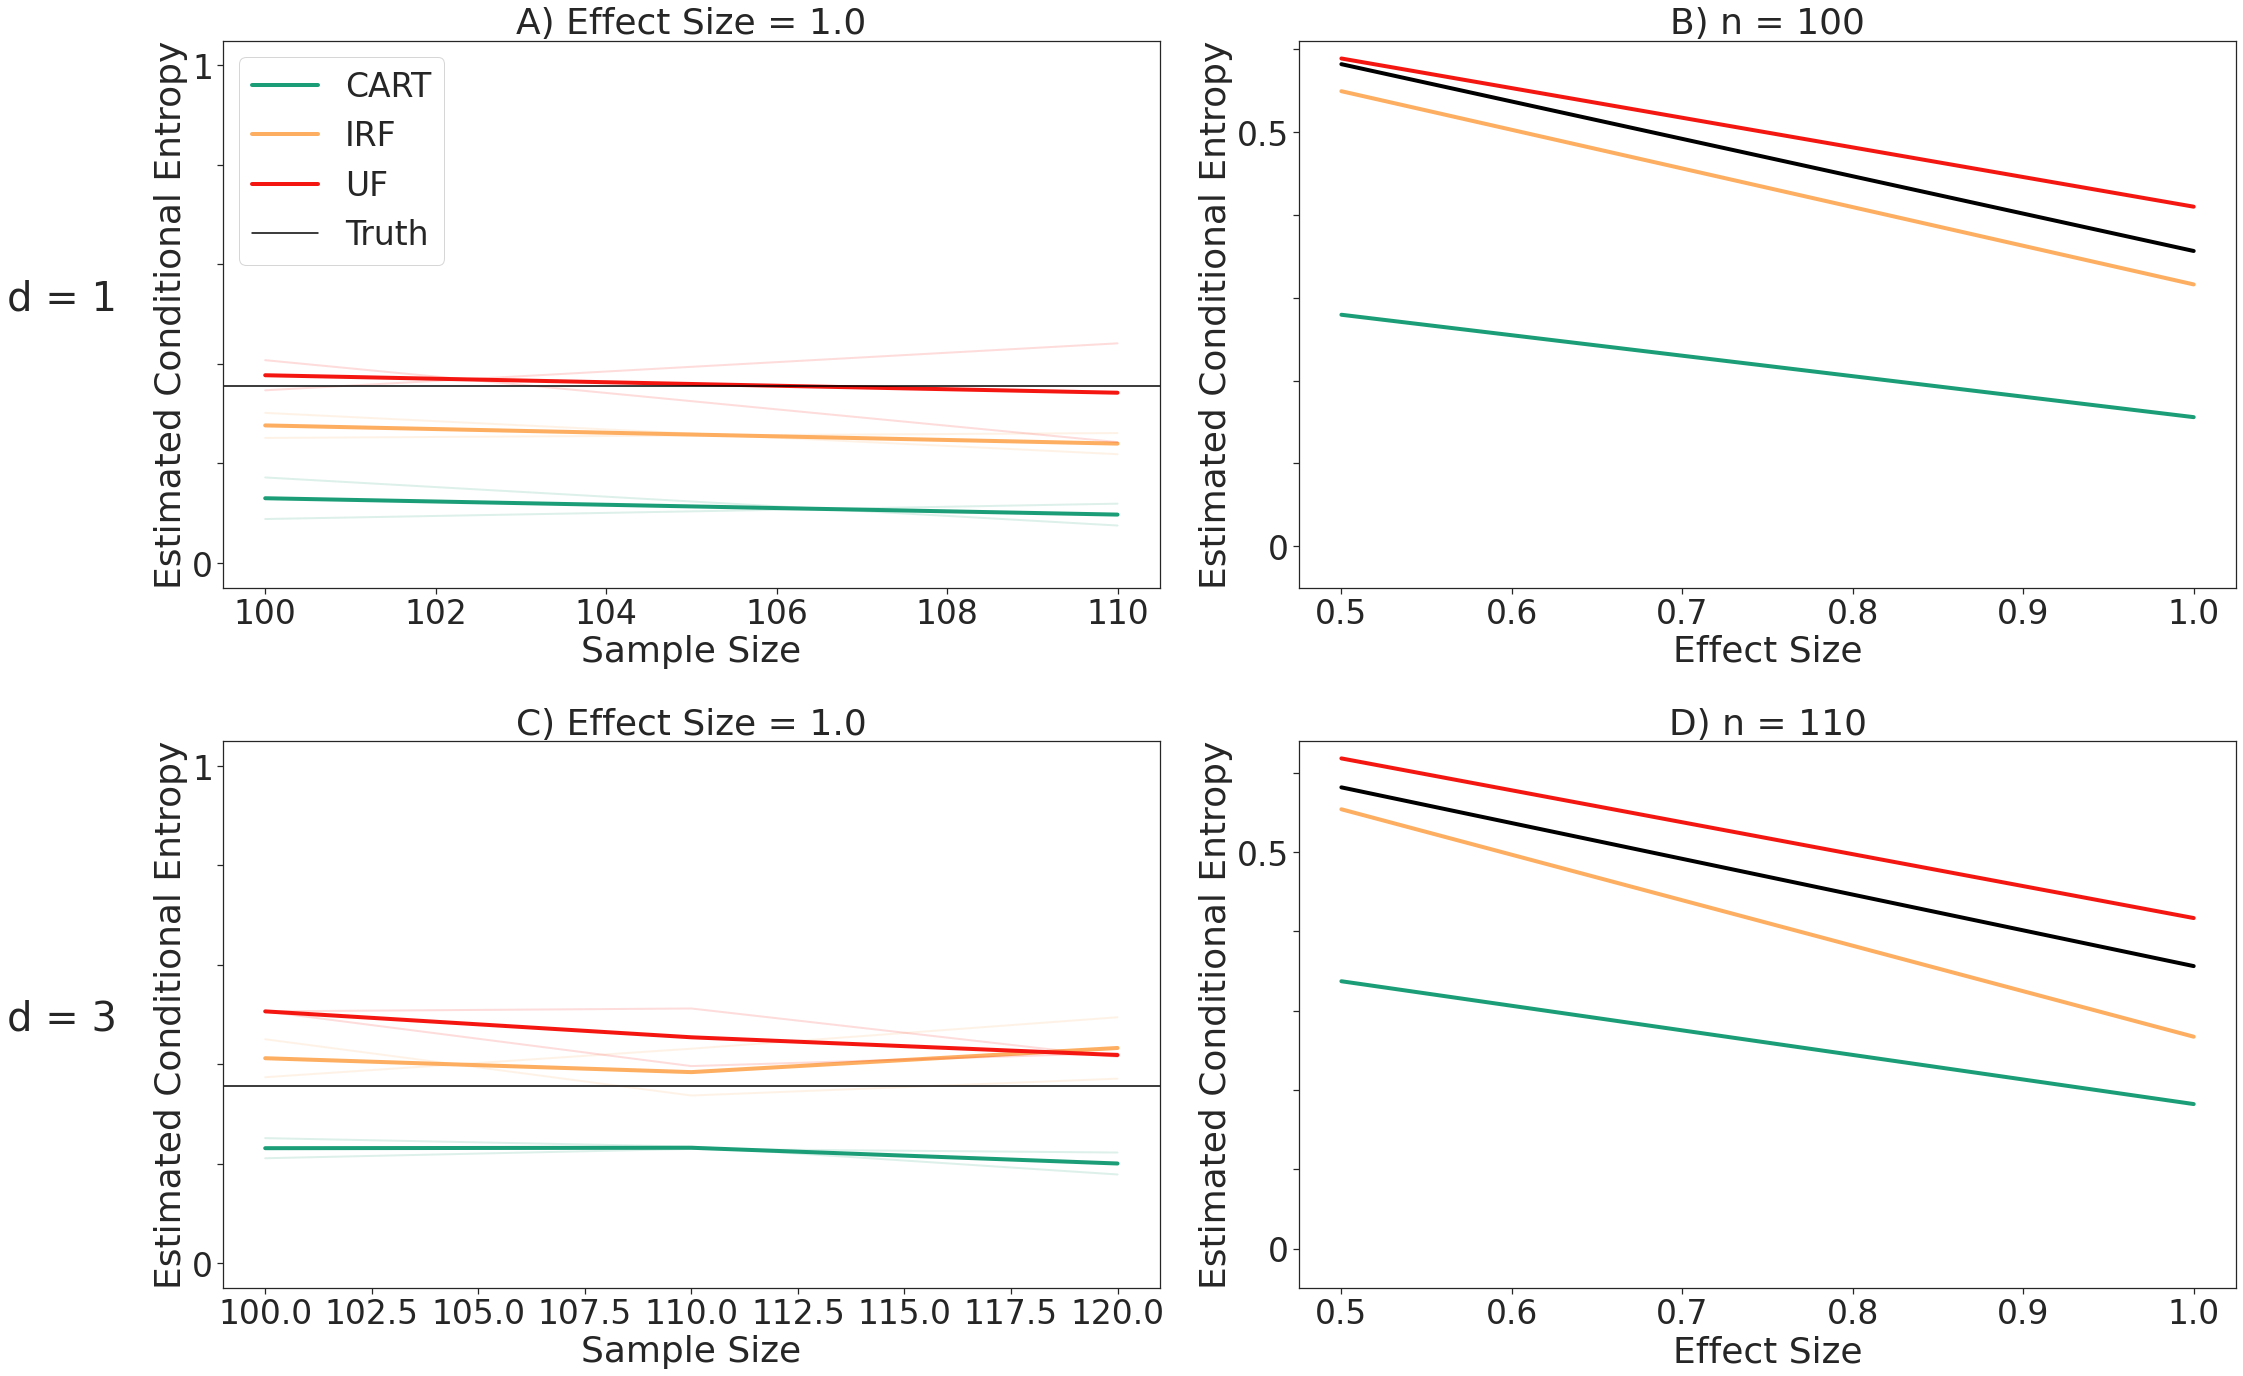

In [9]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)